# DSP

> implements necessary DSP functionality using `torch`

In [ ]:
#| default_exp dsp

In [ ]:
#| export

from enum import Enum
from typing import Optional, Union

import matplotlib.pyplot as plt
import numpy as np
import torch

In [ ]:
# | hide

import IPython.display as ipd
from matplotlib import pyplot as plt

# IIR filters

## Utility Functions

In [ ]:
# | export

def mtanh(
    x: torch.Tensor,
    c: float = 1.0,
    d: float = 1.0,
) -> torch.Tensor:
    return (torch.exp(c * x) - torch.exp(-d * x)) / (torch.exp(c * x) + torch.exp(-d * x))


def constrain_complex_pole_or_zero(
    pole_or_zero: torch.Tensor,
    floor_eps: float = 1e-10,
    ceil_eps: float = 0,
    c: float = 1.0,
    d: float = 1.0,
) -> torch.Tensor:
    """Saturates the absolute value of the complex pole or zero as it approaches the unit
    circle, preventing filter instability."""
    mag = (1.0 - ceil_eps) * torch.abs(pole_or_zero)
    mag = torch.clamp_min(mag, floor_eps)
    return pole_or_zero * mtanh(mag, c, d) / mag 


def pole_or_zero_to_iir_coeff(pole_or_zero: torch.Tensor) -> torch.Tensor:
    """
    Converts a complex pole or zero to IIR coefficients
    """

    c0 = torch.ones(pole_or_zero.shape, device=pole_or_zero.device).float()
    c1 = (-2 * pole_or_zero.real).float()
    c2 = (pole_or_zero.real**2 + pole_or_zero.imag**2).float()

    return torch.stack((c0, c1, c2), dim=-1)


In [ ]:
# | export

def biquad_freqz(
    b: torch.Tensor, # Tensor of shape (..., 3)
    a: torch.Tensor, # Tensor of shape (..., 3)
    n: Union[int, torch.Tensor] = 512, # Number of points to evaluate the frequency response at
) -> torch.Tensor: # Tensor of shape (..., n // 2 + 1)

    numerator = torch.fft.rfft(b, n=n)
    denominator = torch.fft.rfft(a, n=n)

    return numerator / (denominator + 1e-10)

H.shape: torch.Size([65])


<StemContainer object of 3 artists>

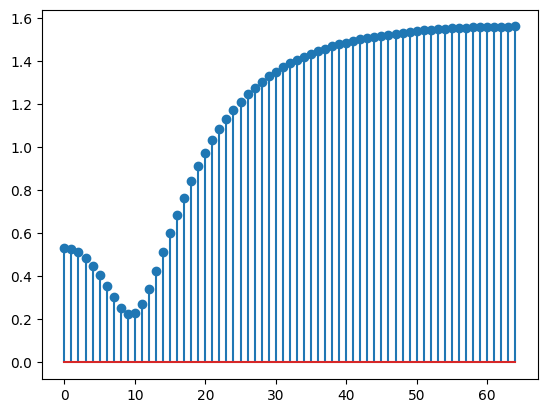

In [ ]:
# create a pole zero pair
pole = torch.complex(real=torch.tensor(0.5), imag=torch.tensor(0.3))
zero = torch.complex(real=torch.tensor(0.8), imag=torch.tensor(-0.4))

# convert to IIR coefficients
b = pole_or_zero_to_iir_coeff(zero)
a = pole_or_zero_to_iir_coeff(constrain_complex_pole_or_zero(pole))

# compute magnitude response
H = biquad_freqz(b, a, 129)
H_mag = H.abs()

# plot
plt.stem(H_mag)

In [ ]:
#| export


def _apply_biquad_fft(
    x: torch.Tensor,  # The input signal
    b: torch.Tensor,  # The biquad numerator coefficients
    a: torch.Tensor,  # The biquad denominator coefficients
) -> torch.Tensor:  # The filtered signal
    """Applies a biquad filter to a signal using the FFT frequency sampling method."""

    # n_fft is given by the length of the signal
    n_fft = x.shape[-1]

    # compute the frequency response
    H = biquad_freqz(b, a, n_fft)

    # compute the FFT
    X = torch.fft.rfft(x)

    # apply the filter
    Y = X * H

    # compute the inverse FFT
    y = torch.fft.irfft(Y)

    return y


def _apply_biquad_tdfii(
    x: torch.Tensor,
    b: torch.Tensor,
    a: torch.Tensor,
    initial_state: torch.Tensor = None,
) -> torch.Tensor:
    """Applies a biquad filter to a signal using the TDF-II algorithm."""
    state = (
        initial_state
        if initial_state is not None
        else torch.zeros(*x.shape[:-1], 2, device=x.device, dtype=x.dtype)
    )

    y = torch.zeros_like(x)

    for n in range(x.shape[-1]):
        y[..., n] = b[..., 0] * x[..., n] + state[..., 0]
        state[..., 0] = b[..., 1] * x[..., n] - a[..., 1] * y[..., n] + state[..., 1]
        state[..., 1] = b[..., 2] * x[..., n] - a[..., 2] * y[..., n]

    return y #, state

## Main Interface

In [ ]:
#| export

class IIRMethod(Enum):
    """An enumeration over IIR computation backends.
    Available options:

    * `IIRMethod.FFT`: Uses the FFT frequency sampling method.
    * `IIRMethod.TDFII`: Uses the TDF-II algorithm.

    """
    FFT = _apply_biquad_fft # The FFT method
    TDFII = _apply_biquad_tdfii # The TDF-II method

In [ ]:
# | export


class IIRParameters:
    """A class for storing IIR filter parameters."""

    def __init__(
        self,
        b: Optional[
            torch.Tensor
        ] = None,  # The numerator coefficients (..., n_parallel, n_biquad, 3)
        a: Optional[
            torch.Tensor
        ] = None,  # The denominator coefficients (..., n_parallel, n_biquad, 3)
        poles: Optional[
            torch.Tensor
        ] = None,  # The complex poles (..., n_parallel, n_biquad)
        zeros: Optional[
            torch.Tensor
        ] = None,  # The complex zeros (..., n_parallel, n_biquad)
        gains: Optional[
            torch.Tensor
        ] = None,  # The filter gains (..., n_parallel, n_biquad)
        constrain_poles: bool = True,  # Whether to constrain the poles to the unit circle
        constrain_zeros: bool = True,  # Whether to constrain the zeros to the unit circle
        constraint_eps: float = 0.0,  # The epsilon value to use for pole/zero constraint
    ):
        # Check what form the filter is specified in
        is_coefficient_form = b is not None and a is not None
        is_pole_zero_form = poles is not None and zeros is not None
        assert (is_coefficient_form and not is_pole_zero_form) or (
            is_pole_zero_form and not is_coefficient_form
        ), "Must specify either biquad coefficients or poles and zeros"

        # Check that the filter is specified correctly
        if is_coefficient_form:
            assert (
                b.shape[-1] == 3 and a.shape[-1] == 3
            ), "Biquad coefficients must be 3-dimensional"
            assert (
                b.shape[-2] == a.shape[-2]
            ), "Number of biquads (dim -2) must be the same for b and a"
            assert (
                b.shape[-3] == a.shape[-3]
            ), "Number of parallel filters (dim -3) must be the same for b and a"
            n_biquads = b.shape[-2]
            n_parallel = b.shape[-3]
        else:
            assert (
                poles.shape[-1] == zeros.shape[-1]
            ), "Number of biquads (dim -1) must be the same for poles and zeros"
            assert (
                poles.shape[-2] == zeros.shape[-2]
            ), "Number of parallel (dim -2) filters must be the same for poles and zeros"
            n_biquads = poles.shape[-1]
            n_parallel = poles.shape[-2]

        # Check that the gains are specified correctly
        if gains is not None:
            assert (
                gains.shape[-1] == n_biquads
            ), "Number of biquads (dim -1) must be the same for gains and poles/zeros or coefficients"
            assert (
                gains.shape[-2] == n_parallel
            ), "Number of parallel (dim -2) filters must be the same for gains and poles/zeros or coefficients"

        # Convert poles and zeros to biquad coefficients, constraining if necessary
        if is_pole_zero_form:
            b = pole_or_zero_to_iir_coeff(
                constrain_complex_pole_or_zero(zeros, constraint_eps)
                if constrain_zeros
                else zeros
            )
            a = pole_or_zero_to_iir_coeff(
                constrain_complex_pole_or_zero(poles, constraint_eps)
                if constrain_poles
                else poles
            )

        self.b = b * (gains[..., None] if gains is not None else 1.0)
        self.a = a
        self.n_biquads = n_biquads
        self.n_parallel = n_parallel

        # ! TODO: Check if coefficients can be NaNs
        # if torch.isnan(self.b).any():
        #     raise ValueError("Numerator coefficients contain NaNs")
        # if torch.isnan(self.a).any():
        #     raise ValueError("Denominator coefficients contain NaNs")

    def freqz(
        self,
        n_fft: Union[int, torch.Tensor],  # The number of frequency bins or the frequencies to use
    ) -> torch.Tensor:
        """Computes the frequency response of the filter structure defined by the given
        parameters."""

        H_ij = biquad_freqz(self.b, self.a, n_fft)

        return H_ij.prod(dim=-2).sum(dim=-2)
    
    def pole_zero_plot(
        self,
        ax: Optional[plt.Axes] = None,  # The axes to plot on
        **kwargs,  # Additional arguments to pass to the plot function
    ) -> plt.Axes:
        """Plots the poles and zeros of the filter structure defined by the given
        parameters."""

        if ax is None:
            fig, ax = plt.subplots(
                figsize=(4, 4),
            )

        # Plot the unit circle
        ax.plot(np.cos(np.linspace(0, 2 * np.pi)), np.sin(np.linspace(0, 2 * np.pi)), linestyle='dashed', color="black")

        # Plot the poles and zeros
        for biquad_idx in range(self.n_biquads):
            for parallel_idx in range(self.n_parallel):
                b = self.b[..., parallel_idx, biquad_idx, :]
                a = self.a[..., parallel_idx, biquad_idx, :]

                # Plot the zeros
                zeros = np.roots(b)
                ax.scatter(zeros.real, zeros.imag, marker="o", edgecolor="black", facecolor="none")

                # Plot the poles
                poles = np.roots(a)
                ax.scatter(poles.real, poles.imag, marker="x", color="black")

        ax.grid()

        # set ticks every 0.25
        ax.set_xticks(np.arange(-1, 1.25, 0.25))
        ax.set_yticks(np.arange(-1, 1.25, 0.25))

        # make spine dashed and thicker
        ax.axhline(y=0, color='k', linestyle='--', linewidth=1)
        ax.axvline(x=0, color='k', linestyle='--', linewidth=1)

        # delete ticks on all sides
        ax.tick_params(
            axis='both',       # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left=False,
            right=False,
            labelbottom=False, # labels along the bottom edge are off
            labelleft=False,
            labelright=False,
            labeltop=False) # labels along the top edge are off

        return ax

    def __repr__(self):
        return f"IIRParameters(b={self.b}, a={self.a}, n_biquads={self.n_biquads}, n_parallel={self.n_parallel})"


We can demonstrate hybrid `freqz` computation by creating a network of passthrough filters:

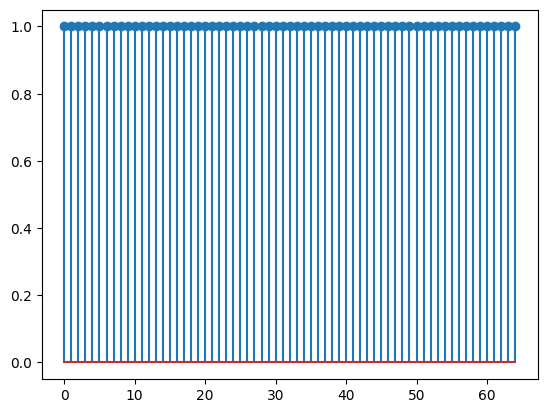

In [ ]:
n_biquads = 15
n_parallel = 8
n_samples = 1000

b = torch.zeros(n_parallel, n_biquads, 3)
b[:, :, 0] = 1.0
a = torch.zeros(n_parallel, n_biquads, 3)
a[:, :, 0] = 1.0

gains = torch.ones(n_parallel, n_biquads) / (n_parallel ** (1 / n_biquads))
params = IIRParameters(b=b, a=a, gains=gains)

plt.stem(params.freqz(128).abs())
plt.show()

In [ ]:
# | export

def apply_iir(
    x: torch.Tensor,  # The input signal (..., time)
    parameters: IIRParameters,  # The IIR filter parameters
    method: IIRMethod = IIRMethod.FFT,  # The method to use for filtering
    expand_x: bool = True,  # Whether to expand the input signal to match the number of parallel filters
    reduce_x: bool = True,  # Whether to sum the output signal along the parallel filter dimension
):
    """Applies a biquad filter to a signal. The filter can be specified in two ways:

    1. Directly as the biquad coefficients (b, a)
    2. As the complex poles and zeros (poles, zeros)

    In both cases, the filter can be specified as a parallel (`n_biquad = 1`),
    cascade (`n_parallel = 1`), or hybrid (`(n_biquad > 1) and
    (n_parallel > 1)`).

    The `method` parameter specifies the method to use for filtering. The FFT method is
    computed without recursion by frequency sampling, while the TDFII method is computed
    recursively using the transposed direct form II structure.
    """
    # prepare the signal variable
    y = x.unsqueeze(-2) if expand_x else x

    if method == IIRMethod.TDFII:
        # hackery necessary to get the right shapes for recursive filter application.
        # we can't rely on torch to broadcast the parallel filter dimension, so we
        # manually expand it here.
        new_shape = list(y.shape)
        new_shape[-2] = parameters.b.shape[-3]
        y = y.expand(*new_shape)

    # apply the filter
    for i in range(parameters.n_biquads):
        y = method(
            y,
            parameters.b[..., i, :],
            parameters.a[..., i, :],
        )

    # return the output, reducing if necessary
    return y.sum(-2) if reduce_x else y


Test that expected shape is returned:

In [ ]:
n_biquads = 2
n_parallel = 9
n_samples = 1000
batch_size = 4

poles = torch.exp(-1j * torch.rand(batch_size, n_parallel, n_biquads) * np.pi)
zeros = torch.exp(-1j * torch.rand(batch_size, n_parallel, n_biquads) * np.pi)
gains = torch.rand(batch_size, n_parallel, n_biquads)
params = IIRParameters(poles=poles, zeros=zeros, gains=gains)

x = torch.rand(batch_size, n_samples)

assert apply_iir(x, params, IIRMethod.FFT).shape == x.shape

In [ ]:
n_biquads = 2
n_parallel = 9
n_samples = 1000
batch_size = 4

b = torch.rand(batch_size, n_parallel, n_biquads, 3)
a = torch.rand(batch_size, n_parallel, n_biquads, 3)
gains = None
params = IIRParameters(b=b, a=a, gains=gains)

x = torch.rand(batch_size, n_samples)

assert apply_iir(x, params, IIRMethod.TDFII).shape == x.shape

We can also have an optimized version of the above

In [ ]:
# | export

from numba import njit

@njit
def apply_filter(
    x_arr: np.ndarray,  # [n_samples]
    a: np.ndarray,  # [n_parallel, n_biquads, 3]
    b: np.ndarray,  # [n_parallel, n_biquads, 3]
    state: Optional[np.ndarray] = None,  # [n_parallel, n_biquads, 2]
):
    n_parallel, n_biquads, c = a.shape
    out = np.zeros_like(x_arr)

    if state is None:
        state = np.zeros((n_parallel, n_biquads, 2))

    for n in range(x_arr.shape[-1]):
        x = x_arr[n]
        y = 0
        for i in range(n_parallel):
            y = x
            o = 0
            for j in range(n_biquads):
                o = b[i, j, 0] * y + state[i, j, 0]
                state[i, j, 0] = b[i, j, 1] * y - a[i, j, 1] * o + state[i, j, 1]
                state[i, j, 1] = b[i, j, 2] * y - a[i, j, 2] * o
                y = o

            out[n] += o

    return out


Test fast filter

In [ ]:
# create a pole zero pair
pole = torch.complex(real=torch.tensor(0.5), imag=torch.tensor(0.3))
zero = torch.complex(real=torch.tensor(0.8), imag=torch.tensor(-0.4))

# convert to IIR coefficients
b = pole_or_zero_to_iir_coeff(zero)
a = pole_or_zero_to_iir_coeff(constrain_complex_pole_or_zero(pole))

b = b.view(1, 1, 3)
a = a.view(1, 1, 3)

impulse = torch.zeros(256)
impulse[0] = 1.0

gains = None
params = IIRParameters(b=b, a=a)
filtered_torch = apply_iir(impulse.unsqueeze(0), params, IIRMethod.TDFII)

filtered = apply_filter(
    x_arr=impulse.cpu().numpy(),
    a = a.cpu().numpy(),
    b = b.cpu().numpy(),
)

# check that the output is the same
assert np.allclose(filtered, filtered_torch[0].detach().cpu().numpy())